# Interlude: How Least Squares Solutions Are Solved Numerically

We want to solve a linear least squares problem:

$$
\min_x \|Ax - b\|_2^2,
$$

where \(A \in \mathbb{R}^{m \times n}\) (with \(m \geq n\)), \(x \in \mathbb{R}^n\), and \(b \in \mathbb{R}^m\).

---

## 1. Normal Equations (theoretical but numerically weak)

Set the gradient to zero:

$$
A^T A x = A^T b.
$$

Then solve for \(x\).

- **Pros**: Simple, easy to derive.  
- **Cons**:  
  - Squaring the condition number of \(A\) → numerical instability.  
  - Requires forming \(A^T A\), which can lose precision.

👉 Rarely used directly in modern numerical libraries.

---

## 2. QR Factorization (most common in practice)

Factorize:

$$
A = QR,
$$

where:
- \(Q \in \mathbb{R}^{m \times n}\) has orthonormal columns,  
- \(R \in \mathbb{R}^{n \times n}\) is upper triangular.

Then:

$$
\min_x \|Ax - b\|_2 = \min_x \|Rx - Q^T b\|_2.
$$

This reduces to solving the triangular system:

$$
R x = Q^T b.
$$

- **Pros**: Stable, efficient.  
- **How**: Computed using **Householder reflections** or **Givens rotations**.

---

## 3. Singular Value Decomposition (SVD)

Factorize:

$$
A = U \Sigma V^T,
$$

where \(\Sigma\) contains the singular values.  
The solution is:

$$
x = V \Sigma^+ U^T b,
$$

with \(\Sigma^+\) the Moore–Penrose pseudoinverse.

- **Pros**:  
  - Most accurate.  
  - Handles rank deficiency (when \(A\) is not full rank).  
- **Cons**: More computationally expensive.

---

## 4. Iterative Methods (for large/sparse problems)

When \(A\) is huge, factorizations aren’t feasible. Iterative solvers are used, which only need matrix-vector products with \(A\) and \(A^T\):

- **CGNE** (Conjugate Gradient for Normal Equations)  
- **CGLS** (Conjugate Gradient for Least Squares)  
- **LSQR** (Lanczos bidiagonalization, stable and widely used)  

- **Pros**: Scales to very large and sparse systems.  
- **Cons**: Convergence can depend on conditioning.

---

## ✅ Summary

- **Small/medium dense problems** → **QR factorization** (default in NumPy, MATLAB, LAPACK).  
- **Ill-conditioned or rank-deficient problems** → **SVD**.  
- **Huge/sparse problems** → **Iterative methods** (LSQR, CGLS).  
- **Normal equations** → Mostly theoretical, not recommended in practice.


## Inverse Problem for a Strike-Slip Fault Using the Screw Dislocation Model

**Problem Statement:**

In this exercise, we will use the antiplane screw dislocation model to simulate and invert for slip on a vertical, surface-breaking strike-slip fault. The fault is discretized into two patches, each with uniform slip. We will generate synthetic surface displacement data, add noise, and use the normal equations to estimate the slip on each patch from the noisy data.

**Physical Model:**

The antiplane screw dislocation solution gives the surface displacement $u(x)$ at a horizontal distance $x$ from the fault due to a vertical strike-slip dislocation (fault) extending from depth $d_1$ to $d_2$ with slip $s$:

$$
u(x; d_1, d_2, s) = \frac{s}{\pi} \left[ \arctan\left(\frac{x}{d_1}\right) - \arctan\left(\frac{x}{d_2}\right) \right]$$

where:
- $x$ = horizontal distance from the fault (km)
- $d_1$, $d_2$ = top and bottom depths of the slip patch (km)
- $s$ = slip on the patch (meters)

The total surface displacement is the sum of contributions from all slip patches. The goal is to invert for the slip on each patch given noisy surface displacement data.

**Tasks:**
- Generate synthetic data using the forward model.
- Add noise to simulate measurement errors.
- Use the normal equations to solve for the slip on each patch.
- Interpret the results and discuss the effect of noise and model discretization.

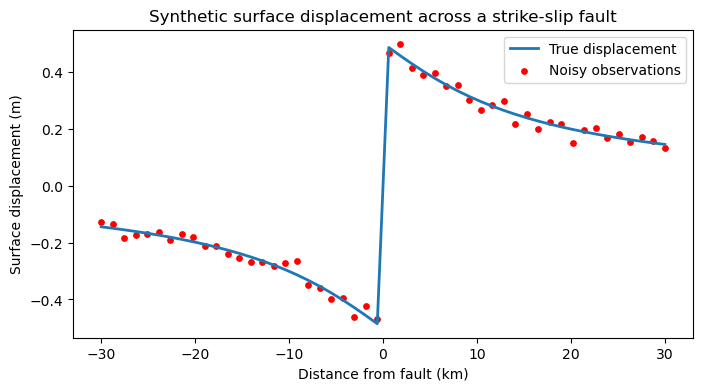

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 20.0  # Fault length (km)
depths = [0, 10, 20]  # Patch boundaries (km)
x_obs = np.linspace(-30, 30, 50)  # Observation points at surface (km)
mu = 30e3  # Shear modulus (MPa)
slip_true = np.array([1.0, 0.5])  # True slip on each patch (meters)

def screw_dislocation_surface_disp(x, d1, d2, slip):
    # Returns surface displacement at x due to slip on a patch from d1 to d2
    # Okada solution for surface-breaking vertical strike-slip
    return (slip / np.pi) * (np.arctan2(x, d1) - np.arctan2(x, d2))

# Build forward matrix G
G = np.zeros((len(x_obs), 2))
for i in range(2):
    G[:, i] = screw_dislocation_surface_disp(x_obs, depths[i], depths[i+1], 1.0)

# Generate synthetic data
d_obs = G @ slip_true
noise = np.random.normal(0, 0.02, size=d_obs.shape)  # Add noise (2 cm std)
d_noisy = d_obs + noise

# Plot synthetic data
plt.figure(figsize=(8, 4))
plt.plot(x_obs, d_obs, label='True displacement', lw=2)
plt.scatter(x_obs, d_noisy, color='red', s=15, label='Noisy observations')
plt.xlabel('Distance from fault (km)')
plt.ylabel('Surface displacement (m)')
plt.legend()
plt.title('Synthetic surface displacement across a strike-slip fault')
plt.show()

In [2]:
# Solve normal equations: m = (G^T G)^(-1) G^T d
GTG = G.T @ G
GTd = G.T @ d_noisy
slip_est = np.linalg.inv(GTG) @ GTd

rank = np.linalg.matrix_rank(G)
print("Rank of G:", rank)
condition_number = np.linalg.cond(GTG)
print("Condition number of G^T G:", condition_number)

print("Estimated slip on each patch (m):", slip_est)
print("True slip on each patch (m):", slip_true)

Rank of G: 2
Condition number of G^T G: 20.970544457225834
Estimated slip on each patch (m): [0.99435586 0.50609874]
True slip on each patch (m): [1.  0.5]


Patches: 2, Condition number of GTG: 2.10e+01
  Estimated slip (first 5): [1.00417525 0.44442384] ...


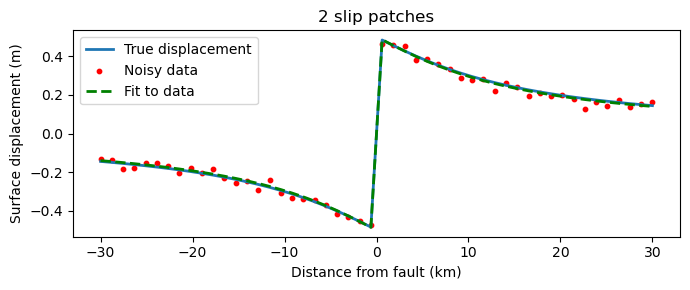

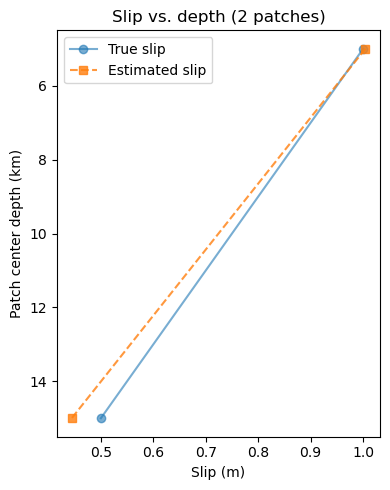

Patches: 3, Condition number of GTG: 7.37e+02
  Estimated slip (first 5): [1.03271059 0.43103602 0.4957374 ] ...


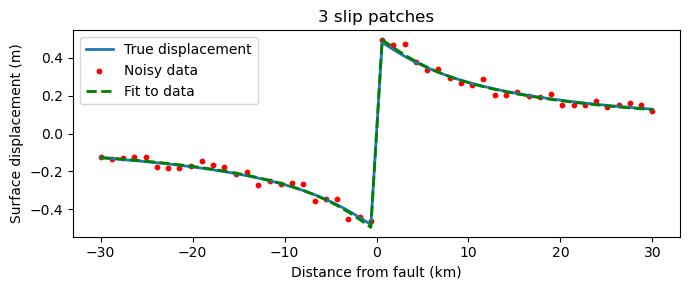

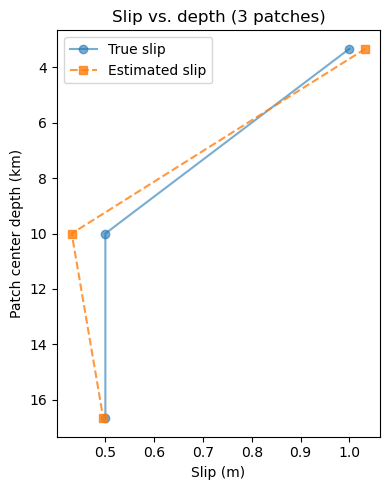

Patches: 4, Condition number of GTG: 2.96e+04
  Estimated slip (first 5): [ 0.99370304  0.94220133 -1.53965182  2.45857493] ...


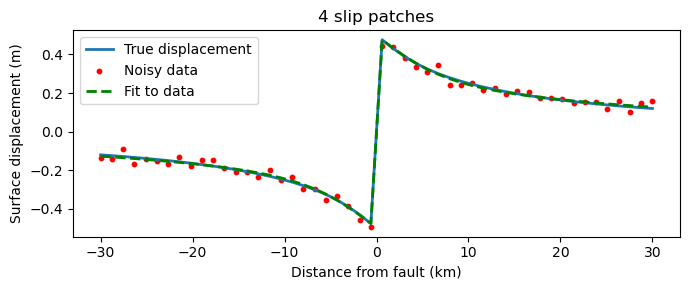

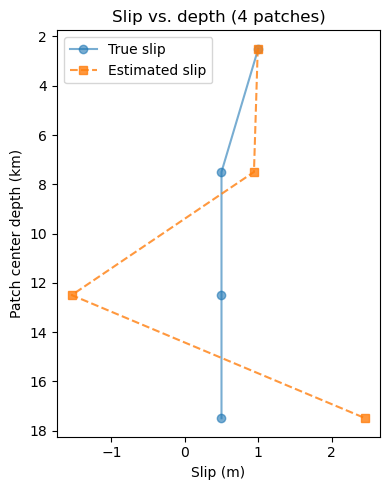

Patches: 5, Condition number of GTG: 1.24e+06
  Estimated slip (first 5): [ 1.00142182 -0.07133309  2.36418983 -1.19169271  0.98271387] ...


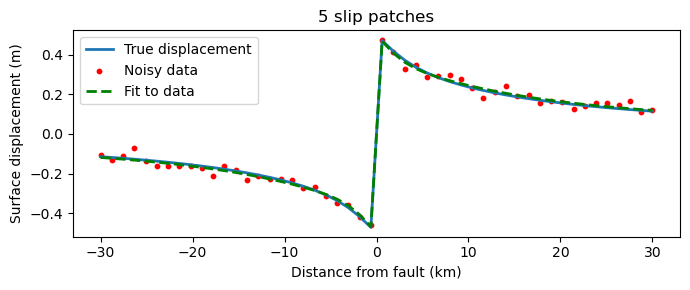

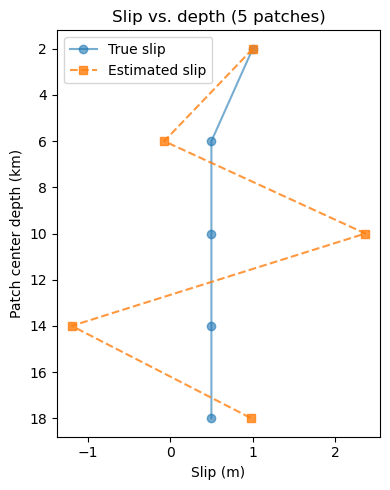

Patches: 6, Condition number of GTG: 5.35e+07
  Estimated slip (first 5): [   0.9975398    -3.32050488   46.56067029 -170.40063103  246.8388245 ] ...


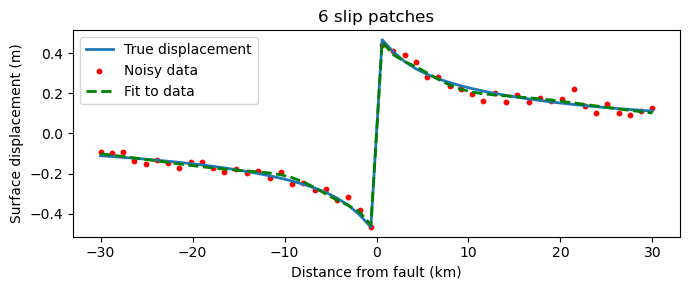

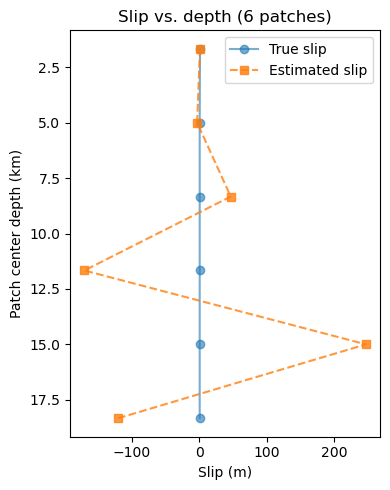

Patches: 7, Condition number of GTG: 2.36e+09
  Estimated slip (first 5): [  0.94878191   1.23164723  -7.82605897  33.50063628 -54.58329775] ...


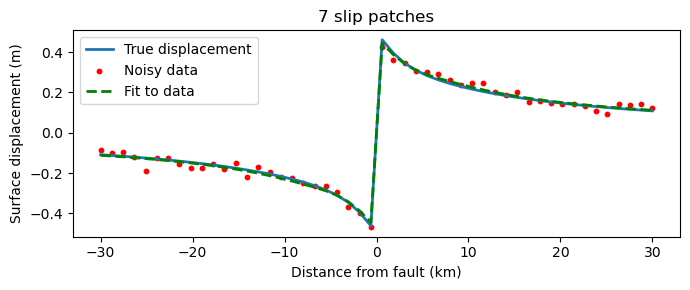

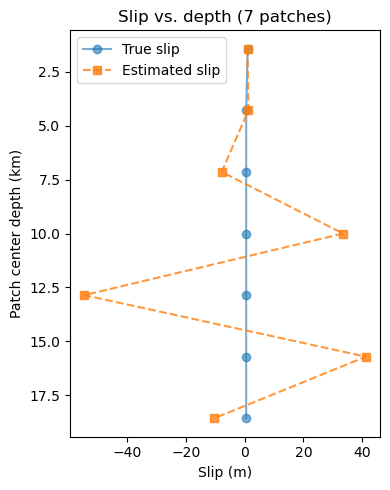

Patches: 8, Condition number of GTG: 1.08e+11
  Estimated slip (first 5): [ 9.20378634e-01  9.84627214e-01  4.58740043e+01 -5.28171401e+02
  2.20922141e+03] ...


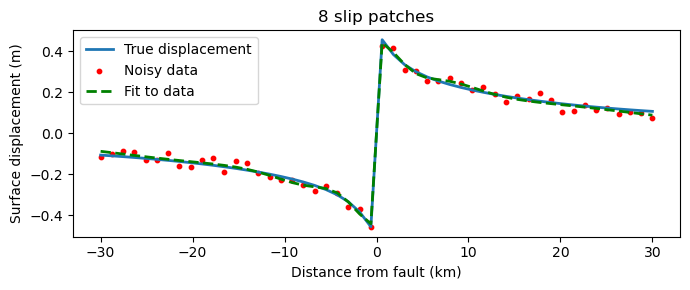

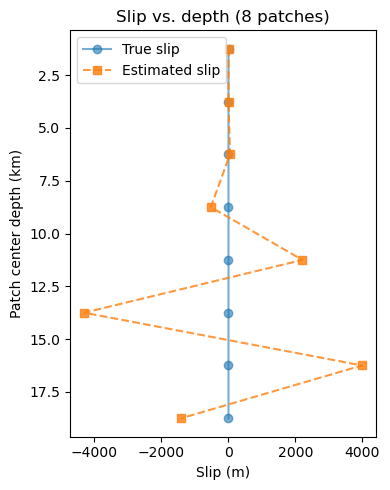

Patches: 9, Condition number of GTG: 5.23e+12
  Estimated slip (first 5): [ 9.78604535e-01  1.36263959e+01 -2.25536961e+02  1.58111742e+03
 -5.82641646e+03] ...


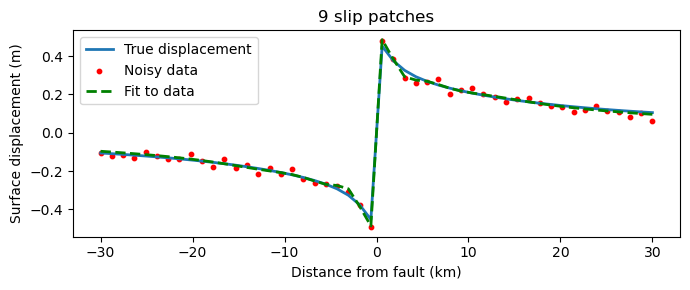

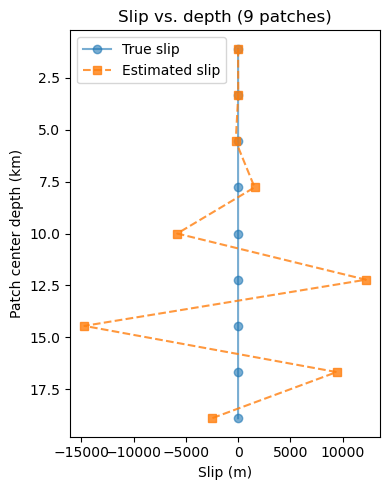

Problem becomes ill-posed at 9 patches (condition number > 1e+12)


In [3]:
# Explore ill-posedness as the number of slip patches increases
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_obs = 50
x_obs = np.linspace(-30, 30, n_obs)
max_patches = 30  # Try up to 30 slip patches
illposed_threshold = 1e12  # Condition number threshold for ill-posedness

illposed_found = False
for n_patches in range(2, max_patches+1):
    # Define patch boundaries (evenly spaced from 0 to 20 km depth)
    depths = np.linspace(0, 20, n_patches+1)
    patch_centers = 0.5 * (depths[:-1] + depths[1:])
    # True slip: 1.0 on first patch, 0.5 on others (arbitrary)
    slip_true = np.ones(n_patches) * 0.5
    slip_true[0] = 1.0
    # Build forward matrix G
    G = np.zeros((len(x_obs), n_patches))
    for i in range(n_patches):
        G[:, i] = (1/np.pi) * (np.arctan2(x_obs, depths[i]) - np.arctan2(x_obs, depths[i+1]))
    # Generate synthetic data
    d_obs = G @ slip_true
    noise = np.random.normal(0, 0.02, size=d_obs.shape)
    d_noisy = d_obs + noise
    # Compute GTG and its condition number
    GTG = G.T @ G
    cond_num = np.linalg.cond(GTG)
    # Solve the inverse problem (if not ill-posed)
    try:
        slip_est = np.linalg.inv(GTG) @ (G.T @ d_noisy)
        d_fit = G @ slip_est
    except np.linalg.LinAlgError:
        print(f"Patches: {n_patches}, GTG is singular (ill-posed)")
        break
    print(f"Patches: {n_patches}, Condition number of GTG: {cond_num:.2e}")
    print(f"  Estimated slip (first 5): {slip_est[:5]} ...")
    # Plot fit to data
    plt.figure(figsize=(7, 3))
    plt.plot(x_obs, d_obs, label='True displacement', lw=2)
    plt.scatter(x_obs, d_noisy, color='red', s=10, label='Noisy data')
    plt.plot(x_obs, d_fit, label='Fit to data', color='green', lw=2, linestyle='--')
    plt.title(f'{n_patches} slip patches')
    plt.xlabel('Distance from fault (km)')
    plt.ylabel('Surface displacement (m)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Plot slip vs. patch center depth
    plt.figure(figsize=(4, 5))
    plt.plot(slip_true, patch_centers, 'o-', label='True slip', alpha=0.6)
    plt.plot(slip_est, patch_centers, 's--', label='Estimated slip', alpha=0.8)
    plt.gca().invert_yaxis()
    plt.xlabel('Slip (m)')
    plt.ylabel('Patch center depth (km)')
    plt.title(f'Slip vs. depth ({n_patches} patches)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    if cond_num > illposed_threshold:
        print(f"Problem becomes ill-posed at {n_patches} patches (condition number > {illposed_threshold:.0e})")
        illposed_found = True
        break

if not illposed_found:
    print(f"No ill-posedness detected up to {max_patches} patches (condition number < {illposed_threshold:.0e})")

### Derivation of the Minimum Norm Solution
Consider the underdetermined linear system:
$$
\mathbf{G} \mathbf{m} = \mathbf{d}
$$
where $\mathbf{G}$ is an $N \times M$ matrix with $N < M$ (more unknowns than equations). There are infinitely many solutions for $\mathbf{m}$ that satisfy the data exactly (if the system is consistent).

The **minimum norm solution** is the solution $\mathbf{m}_\text{min}$ with the smallest Euclidean norm $\|\mathbf{m}\|_2$ among all possible solutions. This is often desirable when we want the "simplest" or least energetic solution.

#### Derivation:
The general solution to $\mathbf{G} \mathbf{m} = \mathbf{d}$ can be written as:
$$
\mathbf{m} = \mathbf{m}_p + \mathbf{n}
$$
where $\mathbf{m}_p$ is a particular solution and $\mathbf{n}$ is any vector in the null space of $\mathbf{G}$ (i.e., $\mathbf{G} \mathbf{n} = 0$).

To find the minimum norm solution, we minimize $\|\mathbf{m}\|_2^2$ subject to $\mathbf{G} \mathbf{m} = \mathbf{d}$. This is a constrained optimization problem, which can be solved using Lagrange multipliers:
$$
L(\mathbf{m}, \boldsymbol{\lambda}) = \frac{1}{2} \|\mathbf{m}\|_2^2 + \boldsymbol{\lambda}^T (\mathbf{d} - \mathbf{G} \mathbf{m})
$$
Setting the gradient with respect to $\mathbf{m}$ to zero:
$$
\nabla_{\mathbf{m}} L = \mathbf{m} - \mathbf{G}^T \boldsymbol{\lambda} = 0 \implies \mathbf{m} = \mathbf{G}^T \boldsymbol{\lambda}
$$
Substitute into the constraint:
$$
\mathbf{G} \mathbf{m} = \mathbf{G} \mathbf{G}^T \boldsymbol{\lambda} = \mathbf{d} \implies \boldsymbol{\lambda} = (\mathbf{G} \mathbf{G}^T)^{-1} \mathbf{d}
$$
Therefore, the minimum norm solution is:
$$
\boxed{\mathbf{m}_\text{min} = \mathbf{G}^T (\mathbf{G} \mathbf{G}^T)^{-1} \mathbf{d}}
$$
This is also known as the Moore-Penrose pseudoinverse solution: $\mathbf{m}_\text{min} = \mathbf{G}^+ \mathbf{d}$, where $\mathbf{G}^+ = \mathbf{G}^T (\mathbf{G} \mathbf{G}^T)^{-1}$.

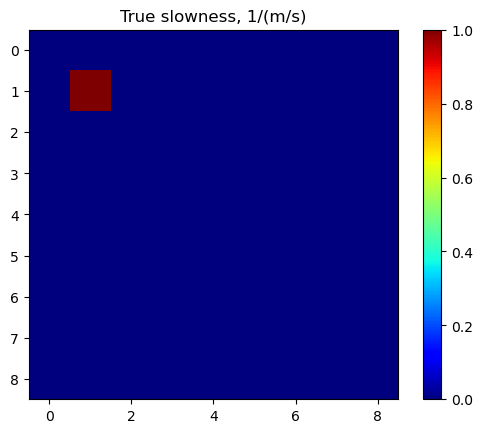

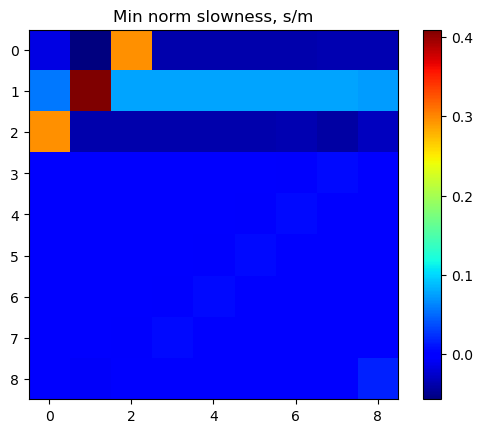

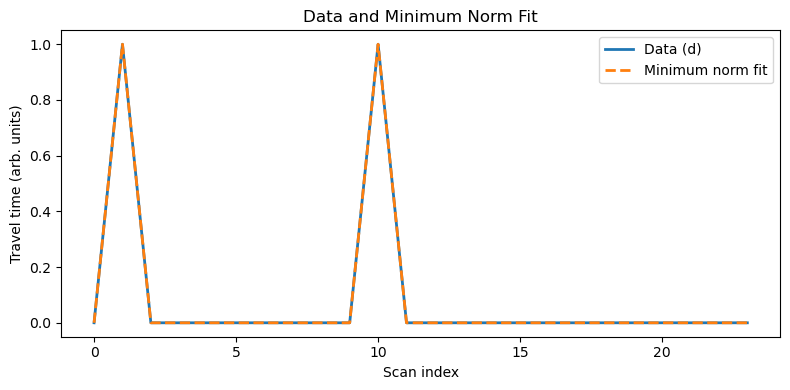

In [4]:
##   Toy minimum norm tomography inversion  
import numpy as np
import matplotlib.pyplot as plt

# Number of rows and columns of grid
numrows = 9
numcols = 9

# Assign slowness values to cells
B = np.zeros((numrows, numcols))
B[1, 1] = 1  # Python is 0-indexed

# Add some noise
B = B + 0.0 * np.random.randn(*B.shape)

cell_length = 1  # m

# Plot true slowness
plt.figure()
plt.imshow(B, cmap='jet', origin='upper')
plt.colorbar()
plt.title('True slowness, 1/(m/s)')
plt.show()

# --- Helper function to build G matrices for horizontal, vertical, and diagonal scans ---
def make_scanG(numrows, numcols, cell_length):
    N = numrows * numcols
    Ghz = []
    Gvert = []
    G1diag = []
    G2diag = []
    # Horizontal scans
    for i in range(numrows):
        row = np.zeros(N)
        for j in range(numcols):
            row[i * numcols + j] = cell_length
        Ghz.append(row)
    # Vertical scans
    for j in range(numcols):
        row = np.zeros(N)
        for i in range(numrows):
            row[i * numcols + j] = cell_length
        Gvert.append(row)
    # Diagonal (\) scans
    for k in range(numrows + numcols - 1):
        row = np.zeros(N)
        for i in range(numrows):
            j = k - i
            if 0 <= j < numcols:
                row[i * numcols + j] = cell_length
        if np.any(row):
            G1diag.append(row)
    # Diagonal (/) scans
    for k in range(-numrows + 1, numcols):
        row = np.zeros(N)
        for i in range(numrows):
            j = i + k
            if 0 <= j < numcols:
                row[i * numcols + j] = cell_length
        if np.any(row):
            G2diag.append(row)
    return np.array(Ghz), np.array(Gvert), np.array(G1diag), np.array(G2diag)

# Build G matrices
Ghz, Gvert, G1diag, G2diag = make_scanG(numrows, numcols, cell_length)

# Remove first and last rows from G1diag and G2diag
# I am doing this simply to make the problem fully underdetermined, otherwise there is redundnacy in the matrix and (G*G')^-1 does not exist
if G1diag.shape[0] > 2:
    G1diag = G1diag[1:-1, :]
if G2diag.shape[0] > 2:
    G2diag = G2diag[1:-1, :]

# G = [Ghz; G1diag] (as in the modified MATLAB code)
G = np.vstack([Ghz, G1diag])

# Make synthetic scans (data)
d = G @ B.flatten()

# Minimum norm solution
GGt = G @ G.T
m = G.T @ np.linalg.inv(GGt) @ d
Best = m.reshape(numrows, numcols)

# Plot minimum norm solution
plt.figure()
plt.imshow(Best, cmap='jet', origin='upper')
plt.colorbar()
plt.title('Min norm slowness, s/m')
plt.show()

# Plot data and minimum norm fit to data
plt.figure(figsize=(8, 4))
plt.plot(d, label='Data (d)', lw=2)
plt.plot(G @ Best.flatten(), label='Minimum norm fit', lw=2, linestyle='--')
plt.xlabel('Scan index')
plt.ylabel('Travel time (arb. units)')
plt.title('Data and Minimum Norm Fit')
plt.legend()
plt.tight_layout()
plt.show()


### Geometry of the Toy Tomography Problem

![Toy tomography grid and scan geometry](tomo_grid.png)

The figure above illustrates the geometry of the toy tomography problem. The grid represents the model space, and the lines show the paths of the horizontal, vertical, and diagonal scans used to collect synthetic travel time data. Each scan sums the slowness values along its path, providing the data used for the inversion.

### Ridge Regression: Generalizing the Minimum Norm Solution

In many inverse problems, the minimum norm solution is appealing because it finds the simplest model that fits the data. However, the minimum norm solution may not always exist, or it may be unstable if the problem is ill-posed or nearly singular. To address this, we introduce **ridge regression** (also known as Tikhonov regularization), which generalizes the minimum norm approach by adding a penalty on the model length.

#### Ridge Regression Formulation

Ridge regression seeks a model $\mathbf{m}$ that minimizes a weighted sum of the squared residuals and the squared norm of the model:

$$
\min_{\mathbf{m}} \left( \|\mathbf{G} \mathbf{m} - \mathbf{d}\|_2^2 + \lambda^2 \|\mathbf{m}\|_2^2 \right)
$$

where $\lambda$ is the regularization parameter that controls the trade-off between fitting the data and keeping the model norm small.

#### Derivation

Setting the gradient with respect to $\mathbf{m}$ to zero gives:

$$
2 \mathbf{G}^T (\mathbf{G} \mathbf{m} - \mathbf{d}) + 2 \lambda^2 \mathbf{m} = 0
$$

which simplifies to:

$$
(\mathbf{G}^T \mathbf{G} + \lambda^2 \mathbf{I}) \mathbf{m} = \mathbf{G}^T \mathbf{d}
$$

This system always has a unique solution for $\lambda > 0$, even if $\mathbf{G}^T \mathbf{G}$ is singular or ill-conditioned.

#### Augmented System Interpretation

Ridge regression is also equivalent to solving the following augmented system of equations:

$$
\begin{bmatrix}
  \mathbf{G} \\
  \lambda \mathbf{I}
\end{bmatrix} \mathbf{m} = \begin{bmatrix}
  \mathbf{d} \\
  \mathbf{0}
\end{bmatrix}
$$

This perspective shows that ridge regression can be viewed as adding $M$ additional equations (where $M$ is the number of model parameters) that penalize large values of $\mathbf{m}$.

#### Interpretation

- For $\lambda = 0$, we recover the ordinary least squares solution.
- For large $\lambda$, the solution is strongly biased toward small model values (shrinking $\mathbf{m}$ toward zero).
- Ridge regression ensures stability and uniqueness, making it a powerful tool for regularizing ill-posed problems.

Ridge regression is widely used in statistics, machine learning, and geophysics to obtain stable solutions when the minimum norm solution is not available or not robust.

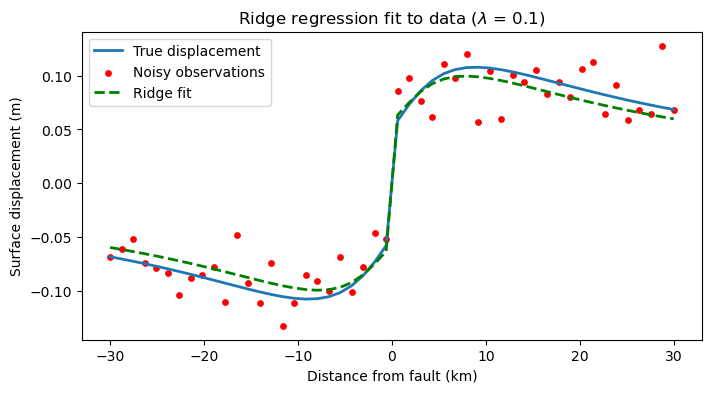

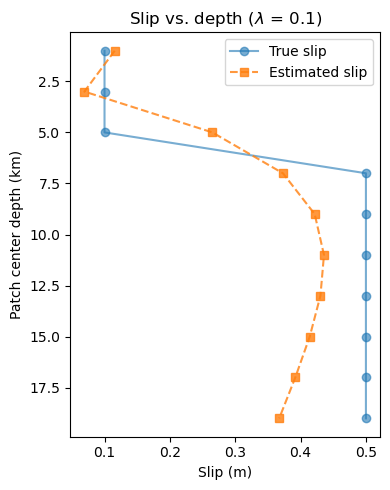

In [5]:
# Ridge regression for a specified lambda: fit to data and slip vs. depth
import numpy as np
import matplotlib.pyplot as plt

# Parameters (same as previous cell)
n_patches = 10
x_obs = np.linspace(-30, 30, 50)
depths = np.linspace(0, 20, n_patches + 1)
patch_centers = 0.5 * (depths[:-1] + depths[1:])
slip_true = np.ones(n_patches) * 0.5
slip_true[0:3] = 0.1

# Build forward matrix G
G = np.zeros((len(x_obs), n_patches))
for i in range(n_patches):
    G[:, i] = (1/np.pi) * (np.arctan2(x_obs, depths[i]) - np.arctan2(x_obs, depths[i+1]))

# Generate synthetic data
d_obs = G @ slip_true
noise = np.random.normal(0, 0.02, size=d_obs.shape)
d_noisy = d_obs + noise

# Ridge regression for a specified lambda
lambda_val = .1  # You can change this value
GTG = G.T @ G
A = GTG + (lambda_val ** 2) * np.eye(n_patches)
b = G.T @ d_noisy
slip_est = np.linalg.solve(A, b)
d_fit = G @ slip_est

# Plot fit to data
plt.figure(figsize=(8, 4))
plt.plot(x_obs, d_obs, label='True displacement', lw=2)
plt.scatter(x_obs, d_noisy, color='red', s=15, label='Noisy observations')
plt.plot(x_obs, d_fit, label='Ridge fit', color='green', lw=2, linestyle='--')
plt.xlabel('Distance from fault (km)')
plt.ylabel('Surface displacement (m)')
plt.legend()
plt.title(f'Ridge regression fit to data ($\\lambda$ = {lambda_val})')
plt.show()

# Plot slip vs. depth
plt.figure(figsize=(4, 5))
plt.plot(slip_true, patch_centers, 'o-', label='True slip', alpha=0.6)
plt.plot(slip_est, patch_centers, 's--', label='Estimated slip', alpha=0.8)
plt.gca().invert_yaxis()
plt.xlabel('Slip (m)')
plt.ylabel('Patch center depth (km)')
plt.title(f'Slip vs. depth ($\\lambda$ = {lambda_val})')
plt.legend()
plt.tight_layout()
plt.show()

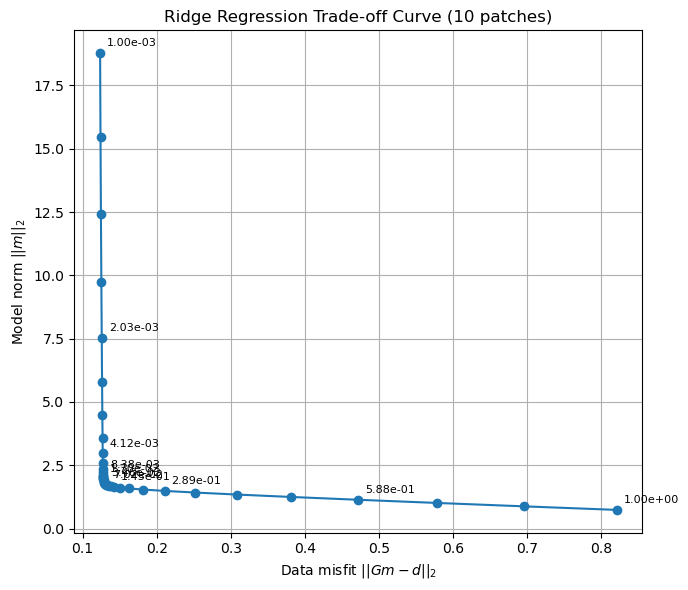

In [6]:
# Ridge regression for screw dislocation problem with 10 patches and trade-off curve
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_patches = 10
x_obs = np.linspace(-30, 30, 50)
depths = np.linspace(0, 20, n_patches + 1)
patch_centers = 0.5 * (depths[:-1] + depths[1:])
slip_true = np.ones(n_patches) * 0.5
slip_true[0] = 1.0

# Build forward matrix G
G = np.zeros((len(x_obs), n_patches))
for i in range(n_patches):
    G[:, i] = (1/np.pi) * (np.arctan2(x_obs, depths[i]) - np.arctan2(x_obs, depths[i+1]))

# Generate synthetic data
d_obs = G @ slip_true
noise = np.random.normal(0, 0.02, size=d_obs.shape)
d_noisy = d_obs + noise

# Range of lambda values (logspace)
lambdas = np.logspace(-3, 0, 40)
data_misfit = []
model_norm = []

for lam in lambdas:
    GTG = G.T @ G
    A = GTG + (lam ** 2) * np.eye(n_patches)
    b = G.T @ d_noisy
    slip_est = np.linalg.solve(A, b)
    misfit = np.linalg.norm(G @ slip_est - d_noisy)
    norm = np.linalg.norm(slip_est)
    data_misfit.append(misfit)
    model_norm.append(norm)

# Plot trade-off curve with lambda labels
plt.figure(figsize=(7, 6))
plt.plot(data_misfit, model_norm, marker='o', linestyle='-')
for i, lam in enumerate(lambdas):
    if i % 4 == 0 or i == len(lambdas) - 1:  # Label every 4th point and the last
        plt.annotate(f"{lam:.2e}", (data_misfit[i], model_norm[i]), textcoords="offset points", xytext=(5,5), fontsize=8)
plt.xlabel('Data misfit $||Gm - d||_2$')
plt.ylabel('Model norm $||m||_2$')
plt.title('Ridge Regression Trade-off Curve (10 patches)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Generalized Tikhonov Regularization

Tikhonov regularization (ridge regression) is commonly used to stabilize solutions to ill-posed problems by penalizing the length (L2 norm) of the model vector $\mathbf{m}$, i.e., adding a term $\lambda^2 \|\mathbf{m}\|_2^2$ to the objective function.

This approach can be generalized by penalizing the L2 norm of any linear operator $\mathbf{L}$ applied to the model vector:

$$
\text{minimize} \quad \|\mathbf{Gm} - \mathbf{d}\|_2^2 + \lambda^2 \|\mathbf{L m}\|_2^2
$$

Here, $\mathbf{L}$ can be, for example, a first-derivative operator (to penalize roughness or enforce smoothness), a second-derivative operator, or any other linear transformation. This flexibility allows Tikhonov regularization to encode prior knowledge or desired properties of the model, such as smoothness or smallness, by choosing an appropriate $\mathbf{L}$.

#### Equations Solved

The minimization problem above leads to the following normal equations for the best-fitting model vector $\mathbf{m}_{\text{est}}$:

$$
(\mathbf{G}^T\mathbf{G} + \lambda^2 \mathbf{L}^T\mathbf{L})\,\mathbf{m}_{\text{est}} = \mathbf{G}^T\mathbf{d}
$$

#### Solution for the Best-Fitting Model Vector

The solution is then:

$$
\mathbf{m}_{\text{est}} = (\mathbf{G}^T\mathbf{G} + \lambda^2 \mathbf{L}^T\mathbf{L})^{-1} \mathbf{G}^T\mathbf{d}
$$

This general form includes standard ridge regression as a special case when $\mathbf{L}$ is the identity matrix.

### Generalized Inverse and Resolution Matrices

The best-fitting model vector in a linear inverse problem can be written using a generalized inverse:

$$
\mathbf{m}_{\text{est}} = \mathbf{G}^{-g} \mathbf{d}
$$

where $\mathbf{G}^{-g}$ is a generalized inverse of $\mathbf{G}$. The specific form of $\mathbf{G}^{-g}$ depends on the method used (e.g., Moore-Penrose pseudoinverse, Tikhonov regularization, truncated SVD, etc.).

#### Model and Data Resolution Matrices

**Model resolution derivation:**

Suppose the observed data are noise-free and generated from a true model $\mathbf{m}_{\text{true}}$:

$$
\mathbf{d}^{\text{obs}} = \mathbf{G} \mathbf{m}_{\text{true}}
$$

Then the estimated model is:

$$
\mathbf{m}_{\text{est}} = \mathbf{G}^{-g} \mathbf{d}^{\text{obs}} = \mathbf{G}^{-g} (\mathbf{G} \mathbf{m}_{\text{true}}) = (\mathbf{G}^{-g} \mathbf{G}) \mathbf{m}_{\text{true}}
$$

So the **model resolution matrix** is:

$$
\mathbf{R}_m = \mathbf{G}^{-g} \mathbf{G}
$$

**Data resolution derivation:**

The predicted data from the estimated model is:

$$
\mathbf{d}_{\text{fit}} = \mathbf{G} \mathbf{m}_{\text{est}} = \mathbf{G} (\mathbf{G}^{-g} \mathbf{d}^{\text{obs}}) = (\mathbf{G} \mathbf{G}^{-g}) \mathbf{d}^{\text{obs}}
$$

So the **data resolution matrix** is:

$$
\mathbf{R}_d = \mathbf{G} \mathbf{G}^{-g}
$$

- $\mathbf{R}_m$ close to the identity matrix means the model is well resolved.
- $\mathbf{R}_d$ close to the identity matrix means the data are well fit.

The choice of generalized inverse affects the properties of these resolution matrices and the stability of the solution.

### Illustration of Model Resolution for Tomography

![Toy tomography resolution 1](Tomo_Resolution1.png)

![Toy tomography resolution 2](Tomo_Resolution2.png)

![Toy tomography resolution 2](Tomo_Resolution3.png)

### The Variance-Resolution Tradeoff in Regularized Inversions

Regularized inversions involve a fundamental tradeoff between **variance** (uncertainty) and **resolution** (ability to recover true model features). This tradeoff is controlled by the regularization parameter $\lambda$.

#### Understanding the Tradeoff

**Low regularization** ($\lambda \approx 0$):
- **High resolution**: The model resolution matrix $\mathbf{R}_m$ approaches the identity matrix, meaning individual model parameters are well resolved
- **High variance**: Solutions are sensitive to noise and can exhibit large fluctuations
- **Risk**: Overfitting to noise, unstable solutions

**High regularization** (large $\lambda$):
- **Low resolution**: Model parameters are smoothed or biased toward the prior (e.g., small values)
- **Low variance**: Solutions are stable and less sensitive to noise
- **Risk**: Underfitting, loss of important model features

#### The Optimal Balance

The goal is to choose $\lambda$ that provides:
- Sufficient resolution to capture the essential features of the true model
- Sufficient regularization to suppress noise and ensure stability

Common approaches to find this balance include:
- **L-curve method**: Plot data misfit vs. model norm and choose the "corner"
- **Cross-validation**: Minimize prediction error on held-out data
- **Generalized Cross-Validation (GCV)**: Statistical criterion for optimal smoothing
- **Discrepancy principle**: Match data misfit to expected noise level

This variance-resolution tradeoff is fundamental to all regularized inverse problems and reflects the inherent limitations of inferring models from noisy, finite data.

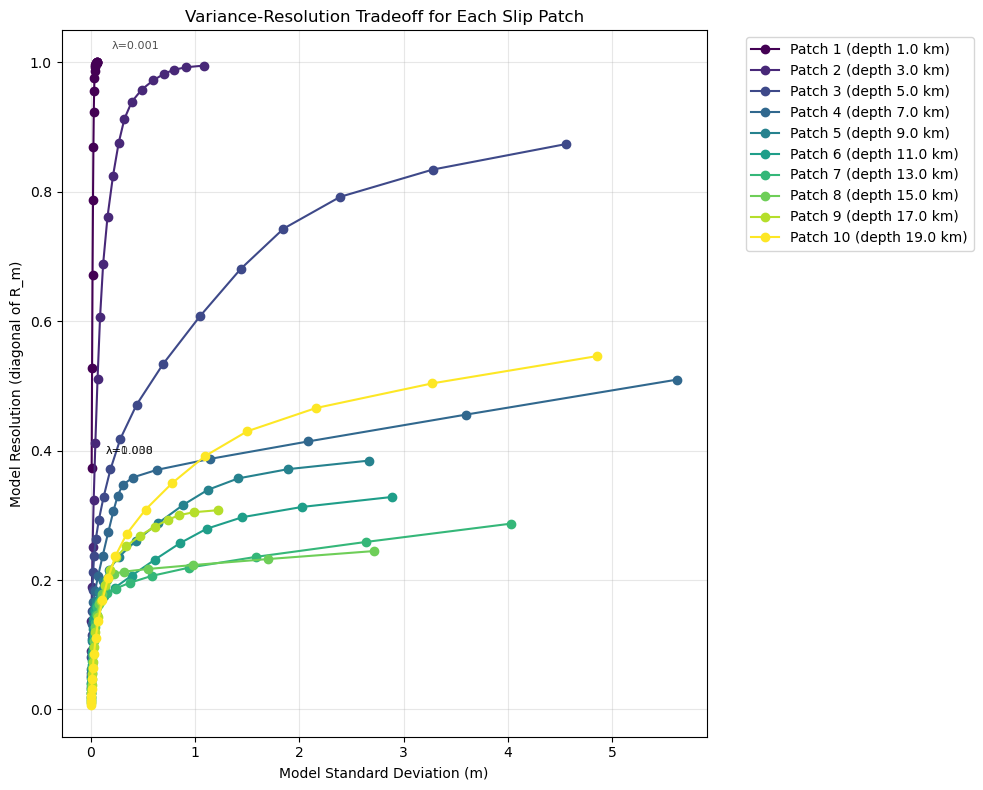

Each curve shows the variance-resolution tradeoff for one slip patch.
As λ increases: resolution decreases (move left), variance decreases (move down).


In [7]:
# Plot model standard deviation vs resolution for each slip patch across different lambda values
import numpy as np
import matplotlib.pyplot as plt

# Parameters (same as ridge regression example)
n_patches = 10
x_obs = np.linspace(-30, 30, 50)
depths = np.linspace(0, 20, n_patches + 1)
patch_centers = 0.5 * (depths[:-1] + depths[1:])
slip_true = np.ones(n_patches) * 0.5
slip_true[0] = 1.0

# Build forward matrix G
G = np.zeros((len(x_obs), n_patches))
for i in range(n_patches):
    G[:, i] = (1/np.pi) * (np.arctan2(x_obs, depths[i]) - np.arctan2(x_obs, depths[i+1]))

# Generate synthetic data
d_obs = G @ slip_true
np.random.seed(42)  # For reproducible results
noise = np.random.normal(0, 0.02, size=d_obs.shape)
d_noisy = d_obs + noise

# Range of lambda values
lambdas = np.logspace(-3, 0, 20)
sigma_noise = 0.02  # Standard deviation of noise

# Storage for results
model_std = []  # Standard deviation for each model parameter
resolution = []  # Resolution (diagonal of model resolution matrix)

for lam in lambdas:
    # Ridge regression matrices
    GTG = G.T @ G
    A_inv = np.linalg.inv(GTG + (lam ** 2) * np.eye(n_patches))
    
    # Model covariance matrix (assuming noise variance = sigma_noise^2)
    model_cov = (sigma_noise ** 2) * A_inv @ GTG @ A_inv
    
    # Model resolution matrix
    R_m = A_inv @ GTG
    
    # Extract diagonal elements (variance and resolution for each parameter)
    model_std.append(np.sqrt(np.diag(model_cov)))
    resolution.append(np.diag(R_m))

model_std = np.array(model_std)
resolution = np.array(resolution)

# Plot for each slip patch
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, n_patches))

for i in range(n_patches):
    plt.plot(model_std[:, i], resolution[:, i], 'o-', 
             color=colors[i], label=f'Patch {i+1} (depth {patch_centers[i]:.1f} km)')

plt.xlabel('Model Standard Deviation (m)')
plt.ylabel('Model Resolution (diagonal of R_m)')
plt.title('Variance-Resolution Tradeoff for Each Slip Patch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add annotations for some lambda values
for j, lam in enumerate([lambdas[0], lambdas[len(lambdas)//2], lambdas[-1]]):
    if j == 0:
        plt.annotate(f'λ={lam:.3f}', 
                    (model_std[j, 0], resolution[j, 0]), 
                    xytext=(10, 10), textcoords='offset points', 
                    fontsize=8, alpha=0.7)
    elif j == len(lambdas)//2:
        mid_idx = len(lambdas)//2
        plt.annotate(f'λ={lambdas[mid_idx]:.3f}', 
                    (model_std[mid_idx, 0], resolution[mid_idx, 0]), 
                    xytext=(10, 10), textcoords='offset points', 
                    fontsize=8, alpha=0.7)
    else:
        plt.annotate(f'λ={lam:.3f}', 
                    (model_std[-1, 0], resolution[-1, 0]), 
                    xytext=(10, 10), textcoords='offset points', 
                    fontsize=8, alpha=0.7)

plt.show()

print("Each curve shows the variance-resolution tradeoff for one slip patch.")
print("As λ increases: resolution decreases (move left), variance decreases (move down).")